Let's make some images in some of the most common browser formats:

In [1]:
exts = ['png', 'jpeg', 'gif', 'svg', 'pdf', 'bmp']

Lets use the Python code below to convert the sample image to base64 and try to output that as Markdown

In [2]:
# A non-trivial string of html code to parse as a test input
source = '<html><head><title>Test</title></head><body><h1>Parse me!</h1></body></html><img src="jupyter.png" alt="Alt_name" title="Mytitle" align="center" /><html><head><title>Test</title></head><body><h1>Parse me!</h1></body></html>'

In [11]:
%%writefile img2base64.py
"""HTML Image handling for embedded images in markdown cells."""

#-----------------------------------------------------------------------------
# Copyright (c) 2013, the IPython Development Team.
#
# Distributed under the terms of the Modified BSD License.
#
# The full license is in the file COPYING.txt, distributed with this software.
#-----------------------------------------------------------------------------

#-----------------------------------------------------------------------------
# Imports
#-----------------------------------------------------------------------------
from ipython_genutils.py3compat import PY3
if PY3:
    from html.parser import HTMLParser
else:
    from HTMLParser import HTMLParser
import base64
import os.path

#-----------------------------------------------------------------------------
# Functions
#-----------------------------------------------------------------------------

__all__ = ['img2base64']


def img2base64(s):
    """Parse HTML image references in Markdown cells.

    This looks for HTML tags having a img tag name `img`
    and converts the image to a data URI for static embedding.
    The tranformation looks like this:

    `<img src="./Images/My_image.png" width="800" height="800" alt="Alt_name" title="Mytitle" align="center" />`

    Becomes

    `<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAADIA..." width="800" height="800" alt="Alt_name" title="Mytitle" align="center" />`

    The conversion preserves all other image tag values.
    """
    parser = Img2Base64Parser()
    parser.feed(s)
    parser.close()
    outtext = u''
    startpos = 0
    for img in parser.imglist:
            outtext += s[startpos:img[1][0]]
            if img[0][1] == 'svg':
                outtext += "data:image/%s+xml;base64,%s"% \
                (img[0][1],str(img[0][0]).lstrip('b\'').rstrip('\''))
            elif img[0][1] == 'pdf':
                outtext += "data:application/%s;base64,%s"% \
                (img[0][1],str(img[0][0]).lstrip('b\'').rstrip('\''))
            else:
                outtext += "data:image/%s;base64,%s"% \
                    (img[0][1],str(img[0][0]).lstrip('b\'').rstrip('\''))
            startpos = img[1][1] if len(img)==3 else -1
    outtext += s[startpos:] if startpos != -1 else ''
    return outtext

#TODO
# def html_img_to_md_img(s):
#     """Parse HTML image references in Markdown cells and output latex format.

#     This looks for HTML tags having a img tag name `img`
#     and any attributes in the list [width, height, alt, src, title].
#     This function won't attempt to handle sizes specified in percentages
#     because Markdown does not:

#     `<img src="./Images/My_image.png" width="800" height="800" alt="Alt_name" title="Mytitle" align="center" />`

#     Becomes

#     `![Alt_name](./Images/My_image.png "Mytitle"){width=800 height=800}`

#     Notice that the `align` attribute is discarded.
    
#     This markdown size specification is not consistent with Jupyter 
#     as of v4.3, but can be used by pandoc when converting to latex and pdf.
#     """
#     parser = Img2mdParser()
#     parser.feed(s)
#     parser.close()
#     outtext = u''
#     startpos = 0
#     for img in parser.imglist:
#             outtext += s[startpos:img.atrdict[]
#             outtext += 'data:image/%s;base64,%s'% \
#                 (img[0][1],str(img[0][0]).lstrip('b\'').rstrip('\''))
#             startpos = img[1][1] if len(img)==3 else -1
#     outtext += s[startpos:] if startpos != -1 else ''
#     return outtext

    
#-----------------------------------------------------------------------------
# Classes
#-----------------------------------------------------------------------------

class Img2Base64Parser(HTMLParser):
    """Image Parser
    Replaces html img file references with base64 encoded strings.
    
    Inherites from HTMLParser, overrides:
     - handle_starttag
     - handle_endtag
     - get_offset
    """
    # number of open tags
    opentags = None
    # list of found imgs
    imglist = None
    # active img tag
    imgtag = None

    def __init__(self):
        self.imglist = []
        self.opentags = 0
        HTMLParser.__init__(self)
    
    def get_offset(self):
        # Compute startposition in source
        lin, offset = self.getpos()
        pos = 0
        for i in range(lin):
            pos = self.data.find('src=',pos) + 5
        return pos
        
    def handle_starttag(self, tag, attrs):
        # for each tag check if attributes are present and convert src to base64
        if self.opentags == 0 and len(attrs)>0:
            for atr, data in attrs:
                if atr.lower() == 'src':
                    self.imgtag = tag
                    self.opentags = 1
                    with open(data, "rb") as image_file:
                        encoded_data = base64.b64encode(image_file.read())
                        extension = os.path.splitext(data)[1][1:].strip().lower()
                        
                    self.imglist.append([[encoded_data, extension],
                                         [self.get_offset(), self.get_offset()+len(data)]])
                    return
                
        if tag == self.imgtag:
            # found an open img tag but not the starting one  
            self.opentags += 1
  
    def handle_endtag(self, tag):
        if tag == self.imgtag:
            # found img tag check if starting one
            if self.opentags == 1:
                pos = self.get_offset()

                self.imglist[-1].append(pos+len(tag)+ 3)
            self.opentags -= 1
        
    def feed(self, data):
        self.data = data
        HTMLParser.feed(self, data)

class Img2mdParser(HTMLParser):
    """Image Parser
    Replaces html img reference with markdown.
    
    Inherites from Img2Base64Parser, overrides:
     - handle_starttag
     - handle_endtag
     - get_offset
    """
    
    # number of open tags
    opentags = None
    # list of found img atrs
    attrdict = None
    # active img tag
    imgtag = None
    
    def __init__(self):
        atrdict = {
            "alt":None,
            "title":None,
            "src":None,
            "width":None,
            "height":None
           }
        self.opentags = 0
        Img2Base64Parser.__init__(self)
    
    def get_offset(self):
        # Compute startposition in source
        lin, offset = self.getpos()
        pos = 0
        for i in range(lin-1):
            pos = self.data.find('\n',pos) + 1
        return pos + offset

    def handle_starttag(self, tag, attrs):
        # for each tag check if attributes are present and convert src to base64
        if self.opentags == 0 and len(attrs)>0:
            for atr, data in attrs:
                self.imgtag = tag
                self.opentags = 1
                if atr in self.atrdict:
                    self.atrdict[atr] = data
                    self.atrdict[atr].append(self.getpos())
            return
                
        if tag == self.imgtag:
            # found an open img tag but not the starting one  
            self.opentags += 1
    def handle_endtag(self, tag):
        if tag == self.imgtag:
            # found img tag check if starting one
            if self.opentags == 1:
                pos = self.get_offset()

                self.imglist[-1].append(pos+len(tag)+ 3)
            self.opentags -= 1
    def feed(self, data):
        self.data = data
        HTMLParser.feed(self, data)
            
            

Writing img2base64.py


In [16]:
from img2base64 import img2base64

In [17]:
from IPython.display import display, Markdown

In [18]:
%%timeit
for ext in exts:
    output = img2base64(source[:].replace('png',ext))
    #uncomment below to display literal HTML and images
#     display(Markdown("###### Literal HTML Code:\n\n"+"`"+output+"`"))
#     display(Markdown("###### Attempting to display the base64 encoding in " + ext+ ":\n\n"))
#     display(Markdown(output))

100 loops, best of 3: 13.2 ms per loop


Is the function fast enough? Not sure how it compares to the regex-based code of juhasch yet.

Lets see how it handles animated gifs really quick

<html><head><title>Test</title></head><body><h1>Parse me!</h1></body></html>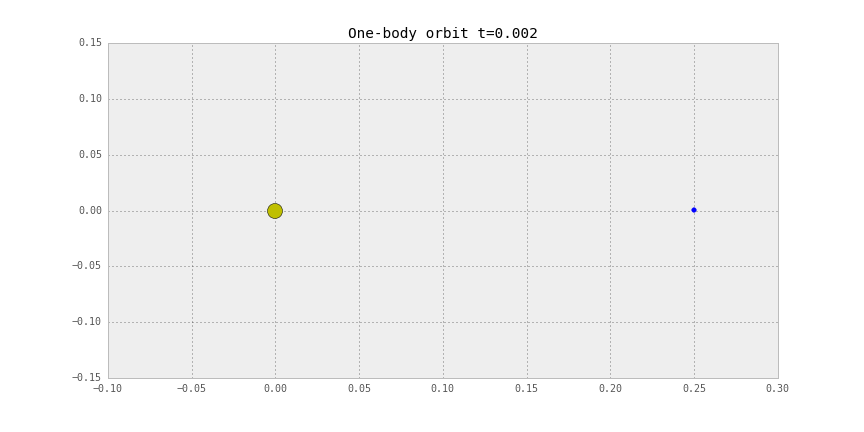<html><head><title>Test</title></head><body><h1>Parse me!</h1></body></html>

In [19]:
source = '<html><head><title>Test</title></head><body><h1>Parse me!</h1></body></html><img src="orbit.gif" alt="Alt_name" title="Mytitle" align="center" /><html><head><title>Test</title></head><body><h1>Parse me!</h1></body></html>'
output = img2base64(source[:].replace('png',ext))
display(Markdown(output))

Looks good!